**4월 21일 변경사항**
1. Fine-tuning, Test 내부 코드 수정
  - 신경망 입력 전 정규화, Classifier층 입력 전 정규화
  - Batch 단위로 입력하며 gradient를 계산하지 않고, full-batch로 연산
2. Weight_decay Scheduler가 적용이 안 됐길래 수정

**확인된 특이사항**
1. ICBHI 공식 split에 따르면 동일 환자는 train/test 중 하나의 set에만 들어가도록 분할했다고 함.  
  그런데 실제로 데이터를 확인해보면 156번, 218번 환자의 청진음들은 train/test set에 섞여 있음
2. 청진음 파일 하나의 이름을 아래와 같이 수정해야 함
  - 226_1b1_Pl_sc_LittC2SE.wav -> 226_1b1_Pl_sc_Meditron.wav
  - 226_1b1_Pl_sc_LittC2SE.txt -> 226_1b1_Pl_sc_Meditron.txt

**BYOL-A 실험 세팅**   

1. 데이터 분할: ICBHI train-test 분할(6:4) 공식 기준에 맞게 분리  
 - Train Data: 539, Test Data: 381, Total: 920  
2. Train data 내 사전훈련 / Fine-tuning 데이터를 분리할 때 동일 환자의 청진음은 하나의 set에만 들어가도록 분리  
 - 사전훈련 / Fine-tuning 8:2로 분리
 - Fine-tuning 시 Validtaion set 만들지 않는 걸로 변경
 - Test Data는 파인튜닝까지 마친 모델을 평가하는 용도로만 사용
3. Augmentation은 BYOL-A 논문 저자들이 제안한 방법을 사용
 - 이 방법으로 고정하여 실험중이므로 SpecAugmentation은 아직 사용하지 않음
 - 논문 저자들이 제안한 방법  
  1) Mixup for foreground acoustic event: 과거에 무작위로 선택된 입력 오디오를 소량 비율로 혼합  
  2) Randomly Resize&Crop: 무작위로 크롭 영역 샘플링 -> bicubic interpolation으로 크기 복구   
4. 전처리 세부사항  
 - 호흡 주기로 끊어준 음성을 5초 길이로 고정
 - 5초보다 짧으면 -> 양 옆 제로 패딩 (음성이 너무 짧으면 충분히 반복해 준 후 양 옆 제로 패딩)
 - 5초보다 길면 -> 랜덤 크롭만 수행
5. 사전훈련 세부사항
 - 옵티마이저: AdamW
 - 활성화함수: GELU
 - Epoch: 최대 150 epoch (15 Linear WarmUp)
 - Sampling rate: 16kHz
 - Weight Decay = 0.4 → 0.04 (코사인 스케줄러)
 - lr 3e-05 → 3e-04 (선형 증가) → 1e-06 (코사인 스케줄러)

#### 환경 설정

In [1]:
!nvidia-smi

Mon Apr 21 18:11:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P0             20W /   72W |       1MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchaudio torchvision pyyaml pytorch_lightning librosa easydict tqdm wandb

In [3]:
import os
import sys
import shutil
import random
import re
import logging
import math
import yaml
import datetime
import pickle
import librosa
from pathlib import Path
from easydict import EasyDict
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import torch
import torchaudio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import wandb

from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelSummary, LearningRateMonitor, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
from itertools import chain

In [4]:
!sudo apt-get install -y gcsfuse
!mkdir -p /mnt/gcs
!gcsfuse hyeonseok_dataset /mnt/gcs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gcsfuse is already the newest version (2.11.1).
0 upgraded, 0 newly installed, 0 to remove and 179 not upgraded.
{"timestamp":{"seconds":1745259097,"nanos":646620337},"severity":"INFO","message":"Start gcsfuse/2.11.1 (Go version go1.24.0) for app \"\" using mount point: /mnt/gcs\n"}
{"timestamp":{"seconds":1745259097,"nanos":646675837},"severity":"INFO","message":"GCSFuse config","config":{"AppName":"","CacheDir":"","Debug":{"ExitOnInvariantViolation":false,"Fuse":false,"Gcs":false,"LogMutex":false},"EnableAtomicRenameObject":false,"EnableHns":true,"FileCache":{"CacheFileForRangeRead":false,"DownloadChunkSizeMb":50,"EnableCrc":false,"EnableODirect":false,"EnableParallelDownloads":false,"ExperimentalParallelDownloadsDefaultOn":false,"MaxParallelDownloads":16,"MaxSizeMb":-1,"ParallelDownloadsPerFile":16,"WriteBufferSize":4194304},"FileSystem":{"DirMode":"755","DisableParallelDirops":false,"Fi

In [5]:
!ls /mnt/gcs

CHECKPOINT  HF_Lung_V1-master  ICBHI  pickle  SPRSound	train_test_split.txt


In [6]:
GCS_DATA_PATH = "/mnt/gcs/ICBHI"

count = 0
if os.path.exists(GCS_DATA_PATH):
    for fname in os.listdir(GCS_DATA_PATH):
        count += 1
    print(f"{count}개의 파일이 확인되었습니다.")
else:
    print("해당 경로가 존재하지 않습니다.")

1840개의 파일이 확인되었습니다.


In [7]:
GCS_DATA_PATH = "/mnt/gcs/ICBHI"
PRETRAINED_MODEL_PATH = "/mnt/gcs/CHECKPOINT"
PICKLE_PATH = "/mnt/gcs/pickle"

In [8]:
!wandb login

wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz). Use `wandb login --relogin` to force relogin


## 0. 데이터셋 구성

#### 0-1. Train-Test Split

파일이름 변경  
- 226_1b1_Pl_sc_LittC2SE.wav -> 226_1b1_Pl_sc_Meditron.wav
- 226_1b1_Pl_sc_LittC2SE.txt -> 226_1b1_Pl_sc_Meditron.txt  
  
텍스트 파일 로드 (ICBHI 공식 train-test 분리 기준)
- info: 파일명에서 얻은 청진 정보 목록  
- rec_annotations: 호흡 주기별 label 목록

In [9]:
patient_number_dict = []
data_split_list = []
file_name_list = []

text = "/mnt/gcs/train_test_split.txt"

with open(text, "r") as file:
    for line in file:
        name, split = line.strip().split("\t")  # txt 파일의 각 줄을 탭으로 분리
        number = int(name.split('_')[0])        # 파일명에서 맨 앞 환자번호 분리

        patient_number_dict.append(number)
        data_split_list.append(split)
        file_name_list.append(name)

##### pickle로 외부 저장

In [10]:
# def Extract_Annotation_Data(file_name, root):
#     tokens = file_name.split('_')
#     recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
#     recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
#     return (recording_info, recording_annotations)

# train_rec_info_dict = {}
# train_rec_annotations_dict = {}
# test_rec_info_dict = {}
# test_rec_annotations_dict = {}

# for i, filename in enumerate(file_name_list):
#     split = data_split_list[i]
#     (info, annotations) = Extract_Annotation_Data(filename, ROOT)
#     if split == 'train':
#         train_rec_info_dict[filename] = info
#         train_rec_annotations_dict[filename] = annotations
#     elif split == 'test':
#         test_rec_info_dict[filename] = info
#         test_rec_annotations_dict[filename] = annotations

In [11]:
# pickle_dict = {
#     'train_rec_info_dict': train_rec_info_dict,
#     'train_rec_annotations_dict': train_rec_annotations_dict,
#     'test_rec_info_dict': test_rec_info_dict,
#     'test_rec_annotations_dict': test_rec_annotations_dict
# }

# save_path = os.path.join(PICKLE_PATH, 'saved_data.pkl')
# with open(save_path, 'wb') as f:
#     pickle.dump(pickle_dict, f)

##### 저장된 데이터 불러오기

In [12]:
save_path = os.path.join(PICKLE_PATH, 'saved_data.pkl')
with open(save_path, 'rb') as f:
    pickle_dict = pickle.load(f)

train_rec_info_dict = pickle_dict['train_rec_info_dict']
train_rec_annotations_dict = pickle_dict['train_rec_annotations_dict']
test_rec_info_dict = pickle_dict['test_rec_info_dict']
test_rec_annotations_dict = pickle_dict['test_rec_annotations_dict']

In [13]:
# 데이터 개수 확인
print(f"Train: {len(train_rec_annotations_dict)}, Test: {len(test_rec_annotations_dict)}, Total: {len(train_rec_annotations_dict)+len(test_rec_annotations_dict)}")

Train: 539, Test: 381, Total: 920


#### 0-2. 사전훈련-파인튜닝 Split

목표 : Train 데이터를 사전훈련 / 파인튜닝 데이터로 재분리 (환자 단위로 분할하여 환자끼리 안 겹치도록 함)

In [14]:
ICBHI_df = pd.DataFrame(data = {'Patient number': patient_number_dict, 'Split': data_split_list}, index=file_name_list)
train_df = ICBHI_df[ICBHI_df['Split']=='train']
test_df = ICBHI_df[ICBHI_df['Split']=='test']

train_patient_counts = train_df['Patient number'].value_counts()
test_patient_counts = test_df['Patient number'].value_counts()

# 환자 수 정보
print(f"Train: {len(train_patient_counts)}, Test: {len(test_patient_counts)}")

Train: 79, Test: 49


In [15]:
train_patient_counts.head()

,count
Patient number,
130,66
107,28
138,27
172,27
186,24


80:20으로 데이터 분할  
이때 130번 환자는 데이터 수가 너무 많으므로, 과적합을 방지하기 위해 Fine-tuning 데이터셋에 미리 할당

In [16]:
# 랜덤하게 데이터 혼합
random.seed(42)
shuffled_patients = list(train_patient_counts.index)
shuffled_patients.remove(130)        # 130번 환자 제거
random.shuffle(shuffled_patients)

# 80%가 될 때까지 데이터 학습
total = train_patient_counts.sum()
pretrain_patients = [130]
pretrain_count = train_patient_counts[130]  # 130번 환자 미리 할당

for p in shuffled_patients:
    if pretrain_count + train_patient_counts[p] <= total * 0.8:
        pretrain_patients.append(p)
        pretrain_count += train_patient_counts[p]
    else:
        break

# 나머지 환자는 finetune 그룹
finetune_patients = [p for p in shuffled_patients if p not in pretrain_patients]

# 데이터프레임 분할
pretrain_df = train_df[train_df['Patient number'].isin(pretrain_patients)]
finetune_df = train_df[train_df['Patient number'].isin(finetune_patients)]

# 결과 확인
print(f"사전훈련 데이터 수: {len(pretrain_df)}, 환자 수: {len(pretrain_patients)}")
print(f"파인튜닝 데이터 수: {len(finetune_df)}, 환자 수: {len(finetune_patients)}")
print(f"평가 데이터 수: {len(test_df)}, 환자 수: {len(test_patient_counts)}")

사전훈련 데이터 수: 428, 환자 수: 65
파인튜닝 데이터 수: 111, 환자 수: 14
평가 데이터 수: 381, 환자 수: 49


사전훈련 / 파인튜닝 info_dict와 annotations_dict 구축

In [17]:
# 결과 딕셔너리 생성
split_info_data = {
    "pretrain": {key: train_rec_info_dict[key] for key in list(pretrain_df.index)},
    "finetune": {key: train_rec_info_dict[key] for key in list(finetune_df.index)},
}
split_annotations_data = {
    "pretrain": {key: train_rec_annotations_dict[key] for key in list(pretrain_df.index)},
    "finetune": {key: train_rec_annotations_dict[key] for key in list(finetune_df.index)},
}

In [18]:
# 사전훈련 / 파인튜닝 데이터의 info 데이터 구축 ('Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment')
pretrain_rec_info_dict = split_info_data['pretrain']
finetune_rec_info_dict = split_info_data['finetune']

# 사전훈련 / 파인튜닝 데이터의 annotation 데이터 구축 ('Start', 'End', 'Crackles', 'Wheezes')
pretrain_rec_annotations_dict = split_annotations_data['pretrain']
finetune_rec_annotations_dict = split_annotations_data['finetune']

# 데이터 개수 확인
print(f"사전훈련용 info 데이터       : {len(pretrain_rec_info_dict)}, 파인튜닝용 info 데이터        : {len(finetune_rec_info_dict)}")
print(f"사전훈련용 annotation 데이터 : {len(pretrain_rec_annotations_dict)}, 파인튜닝용 annotation 데이터  : {len(finetune_rec_annotations_dict)}")

사전훈련용 info 데이터       : 428, 파인튜닝용 info 데이터        : 111
사전훈련용 annotation 데이터 : 428, 파인튜닝용 annotation 데이터  : 111


#### 0-3. 파일경로 데이터 구축

In [19]:
files = sorted(Path(GCS_DATA_PATH).glob('*.wav'))

# split_annotations_data['pretrain']에 해당하는 파일명만 필터링
pretrain_filenames = set(split_annotations_data["pretrain"].keys())  # pretrain 데이터의 파일명 집합 생성
pretrain_files = [f for f in files if f.stem in pretrain_filenames]  # 파일명(stem) 기준 필터링

# split_annotations_data['finetune']에 해당하는 파일명만 필터링
finetune_filenames = set(split_annotations_data["finetune"].keys())  # finetune 데이터의 파일명 집합 생성
finetune_files = [f for f in files if f.stem in finetune_filenames]  # 파일명(stem) 기준 필터링

# test_rec_annotations_dict에 해당하는 파일명만 필터링
test_filenames = set(test_rec_annotations_dict.keys())               # test 데이터의 파일명 집합 생성
test_files = [f for f in files if f.stem in test_filenames]          # 파일명(stem) 기준 필터링

# 데이터 개수 확인
print(f"사전훈련용 데이터: {len(pretrain_files)}, 파인튜닝용 데이터: {len(finetune_files)}, 평가용 데이터: {len(test_files)}")

사전훈련용 데이터: 427, 파인튜닝용 데이터: 111, 평가용 데이터: 381


## 1. 데이터 EDA

#### 1-1. 호흡 주기 분포 확인

In [20]:
def get_duration_list(rec_annotations_dict):
    duration_list = []
    rec_annotations = list(rec_annotations_dict.values())

    for i in range(len(rec_annotations)):
        current = rec_annotations[i]
        duration = current['End'] - current['Start']
        duration_list.extend(duration)

    return np.array(duration_list)

pretrain_duration_list = get_duration_list(pretrain_rec_annotations_dict)
finetune_duration_list = get_duration_list(finetune_rec_annotations_dict)
test_duration_list = get_duration_list(test_rec_annotations_dict)

(1) 사전훈련 데이터

the number of cycles: 3268
longest cycle: 16.163
shortest cycle: 0.1999999999999993
Fraction of samples less than 4 seconds:0.8996328029375765


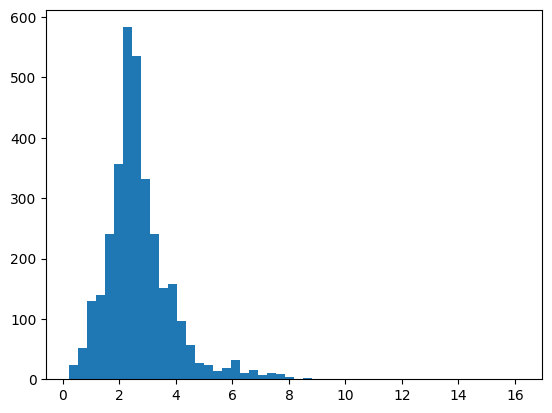

In [21]:
plt.hist(pretrain_duration_list, bins = 50)

print('the number of cycles: {}'.format(len(pretrain_duration_list)))
print('longest cycle: {}'.format(max(pretrain_duration_list)))
print('shortest cycle: {}'.format(min(pretrain_duration_list)))

threshold = 4
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(pretrain_duration_list < threshold)/len(pretrain_duration_list)))

(2) Fine-tuning 데이터

the number of cycles: 874
longest cycle: 11.204999999999998
shortest cycle: 0.2569999999999979
Fraction of samples less than 4 seconds:0.7723112128146453


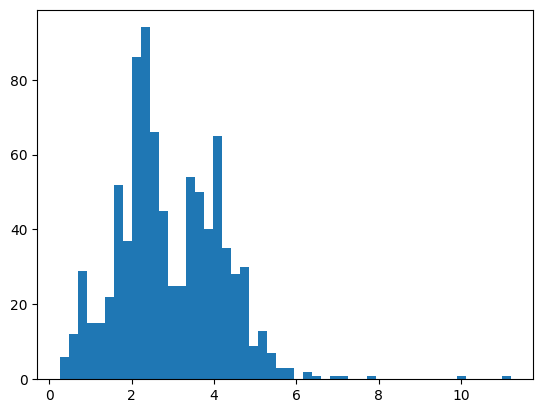

In [22]:
plt.hist(finetune_duration_list, bins = 50)

print('the number of cycles: {}'.format(len(finetune_duration_list)))
print('longest cycle: {}'.format(max(finetune_duration_list)))
print('shortest cycle: {}'.format(min(finetune_duration_list)))

threshold = 4
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(finetune_duration_list < threshold)/len(finetune_duration_list)))

(3) Test 데이터

the number of cycles: 2756
longest cycle: 9.217
shortest cycle: 0.228
Fraction of samples less than 4 seconds:0.9034833091436865


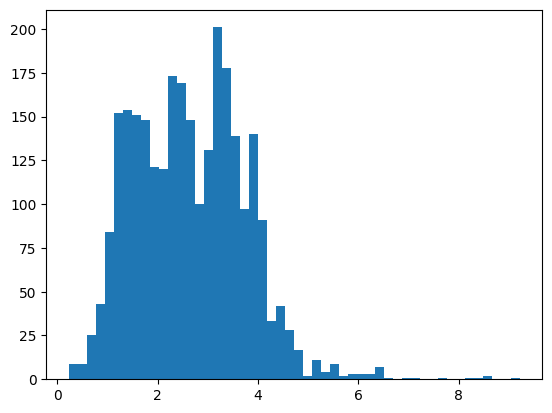

In [23]:
plt.hist(test_duration_list, bins = 50)

print('the number of cycles: {}'.format(len(test_duration_list)))
print('longest cycle: {}'.format(max(test_duration_list)))
print('shortest cycle: {}'.format(min(test_duration_list)))

threshold = 4
print('Fraction of samples less than {} seconds:{}'.format(threshold, np.sum(test_duration_list < threshold)/len(test_duration_list)))

#### 1-2. Label 분포 확인

In [24]:
def get_label_list(name, rec_annotations_dict):

    no_label_list = []    # Normal
    crack_list = []       # Crackle Only
    wheeze_list = []      # Wheeze Only
    both_sym_list = []    # Both

    for f,d in rec_annotations_dict.items():
        no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
        n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
        n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
        both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
        no_label_list.append(no_labels)
        crack_list.append(n_crackles)
        wheeze_list.append(n_wheezes)
        both_sym_list.append(both_sym)

    df = pd.DataFrame(data = {'normal':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'both':both_sym_list})
    label_df = df.sum(axis=0).to_frame()
    label_df.columns = [name]

    return label_df

In [25]:
pretrain_label_df = get_label_list('Pretrain', pretrain_rec_annotations_dict)
finetune_label_df = get_label_list('Finetune', finetune_rec_annotations_dict)
train_label_df = get_label_list('Train', train_rec_annotations_dict)
test_label_df = get_label_list('Test', test_rec_annotations_dict)

pd.concat([pretrain_label_df, finetune_label_df, train_label_df, test_label_df], axis=1)

,Pretrain,Finetune,Train,Test
normal,1621,442,2063,1579
crackles only,1043,172,1215,649
wheezes only,349,152,501,385
both,255,108,363,143


In [26]:
print(f"사전훈련 데이터 수: {len(pretrain_df)}, 환자 수: {len(pretrain_patients)}")
print(f"파인튜닝 데이터 수: {len(finetune_df)}, 환자 수: {len(finetune_patients)}")
print(f"\nTrain 데이터 수   : {len(train_df)}, 환자 수: {len(train_patient_counts)}")
print(f"Test 데이터 수    : {len(test_df)}, 환자 수: {len(test_patient_counts)}")

사전훈련 데이터 수: 428, 환자 수: 65
파인튜닝 데이터 수: 111, 환자 수: 14

Train 데이터 수   : 539, 환자 수: 79
Test 데이터 수    : 381, 환자 수: 49


## 2. 데이터 전처리  

#### 2-1. 호흡 주기 분할

In [27]:
def _slice_data_torchaudio(start, end, data, sample_rate):
    """
    SCL paper..
    sample_rate denotes how many sample points for one second
    """
    max_ind = len(data)
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)

    return data[start_ind: end_ind]


def _get_lungsound_label(crackle, wheeze):
    if crackle == 0 and wheeze == 0:
        return 0
    elif crackle == 1 and wheeze == 0:
        return 1
    elif crackle == 0 and wheeze == 1:
        return 2
    elif crackle == 1 and wheeze == 1:
        return 3


def get_individual_cycles_torchaudio(recording_annotations, wav, sample_rate):
    """
    SCL paper..
    used to split each individual sound file into separate sound clips containing one respiratory cycle each
    output: [(audio_chunk:np.array, label:int), (...)]
    """
    sample_data = []
    # fpath = os.path.join(data_folder, filename)

    # sr = librosa.get_samplerate(fpath)
    # data, _ = torchaudio.load(fpath)

    for idx in recording_annotations.index:
        row = recording_annotations.loc[idx]

        start = row['Start'] # time (second)
        end = row['End'] # time (second)
        audio_chunk = _slice_data_torchaudio(start, end, wav, sample_rate)

        crackles = row['Crackles']
        wheezes = row['Wheezes']
        sample_data.append((audio_chunk, _get_lungsound_label(crackles, wheezes)))

    return sample_data

#### 2-2. Log mel spectrogram 변환  
- WaveInLMSOutDataset 클래스 정의  
- zero-padding, random crop을 통한 전처리 방법 정의
- n_frames = floor{(unit_sec*sample_rate - n_fft) / hop_length} + 1

In [28]:
class MelSpectrogramLibrosa:
    """Mel spectrogram using librosa."""
    def __init__(self, fs=16000, n_fft=1024, shift=160, n_mels=64, fmin=60, fmax=7800):
        self.fs, self.n_fft, self.shift, self.n_mels, self.fmin, self.fmax = fs, n_fft, shift, n_mels, fmin, fmax
        self.mfb = librosa.filters.mel(sr=fs, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)

    def __call__(self, audio):
        X = librosa.stft(np.array(audio), n_fft=self.n_fft, hop_length=self.shift)
        return torch.tensor(np.matmul(self.mfb, np.abs(X)**2))      # [n_mels, n_frames] 반환


class WaveInLMSOutDataset(Dataset):
    """Wave in, log-mel spectrogram out, dataset class.

    Choosing librosa or torchaudio:
        librosa: Stable but slower.
        torchaudio: Faster but cannot reproduce the exact performance of pretrained weight,
            which might be caused by the difference with librosa. Librosa was used in the pretraining.

    Args:
        cfg: Configuration settings.
        mode: Purpose of constructing this dataset. ('train', 'finetune' and 'test')
        audio_files: List of audio file pathnames.
        tfms: Transforms (augmentations), callable.
        use_labels: True if using labels (fine-tuning or evaluation).
        use_librosa: True if using librosa for converting audio to log-mel spectrogram (LMS).

    Returns:
        LMS if use_labels=False.
        (LMS, label) if use_labels=True.
        shape of LMS: (1, n_mels, time)
    """

    def __init__(self, cfg, mode, audio_files, tfms=None, use_labels=False, use_librosa=False):
        # argment check
        assert mode in ['train', 'finetune', 'test'], 'Argument "mode" must be one of: "train", "finetune" or "test".'
        super().__init__()

        self.cfg = cfg
        self.mode = mode
        self.files = audio_files
        self.tfms = tfms
        self.use_labels = use_labels
        self.audio_cycle_wavs = []          # 입력받은 audio를 호흡 cycle 단위로 분해하여 저장
        self.audio_cycle_labels = []        # label을 입력받은 경우, 각 cycle에 부여된 label을 저장
        self.unit_length = int(cfg.unit_sec * cfg.sample_rate)
        self.to_melspecgram = MelSpectrogramLibrosa(
            fs=cfg.sample_rate,
            n_fft=cfg.n_fft,
            shift=cfg.hop_length,
            n_mels=cfg.n_mels,
            fmin=cfg.f_min,
            fmax=cfg.f_max,
        ) if use_librosa else T.MelSpectrogram(
            sample_rate=cfg.sample_rate,
            n_fft=cfg.n_fft,
            win_length=cfg.win_length,
            hop_length=cfg.hop_length,
            n_mels=cfg.n_mels,
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            power=2,
        )

        # 데이터 로드
        if self.mode == 'train':
            rec_annotations_dict = pretrain_rec_annotations_dict
        elif self.mode == 'finetune':
            rec_annotations_dict = finetune_rec_annotations_dict
        elif self.mode == 'test':
            rec_annotations_dict = test_rec_annotations_dict

        # 각 wav 파일을 처리하여 호흡 주기 단위로 저장
        for file in self.files:
            wav, sr = torchaudio.load(file)

            # Resample if needed
            if sr != self.cfg.sample_rate:
                resampler = T.Resample(orig_freq=sr, new_freq=self.cfg.sample_rate)
                wav = resampler(wav)

            # Ensure single channel
            assert wav.shape[0] == 1, f'Convert .wav files to single channel audio, {file} has {wav.shape[0]} channels.'
            wav = wav[0]  # (1, length) -> (length,)

            # 호흡 cycle 분할
            annotation = rec_annotations_dict[file.stem]
            cycles = get_individual_cycles_torchaudio(annotation, wav, self.cfg.sample_rate)

            for cycle, label in cycles:
                self.audio_cycle_wavs.append(cycle)
                # label을 포함한 데이터셋을 구축하는 경우
                if self.use_labels:
                    # 각 cycle에 부여된 label을 저장
                    self.audio_cycle_labels.append(label)

    def __len__(self):
        return len(self.audio_cycle_wavs)  # 전체 호흡 cycle 개수

    def __getitem__(self, idx):
        cycle = self.audio_cycle_wavs[idx]

        # zero padding: unit_length보다 짧은 경우, 양쪽에 0-padding 추가
        length_adj = self.unit_length - len(cycle)
        if length_adj > 0:
            half_unit = self.unit_length // 2

            if length_adj < half_unit:
                # 길이 차이가 unit_length의 절반보다 작다면 zero padding 적용
                half_adj = length_adj // 2
                cycle = F.pad(cycle, (half_adj, length_adj - half_adj))
            else:
                # 길이 차이가 unit_length의 절반보다 크다면 충분히 cycle 반복하여 채우고 zero padding 적용
                repeat_factor = (self.unit_length // len(cycle))        # 반복 횟수 결정
                cycle = cycle.repeat(repeat_factor)[:self.unit_length]  # 필요한 길이만큼 자름
                remaining_length = self.unit_length - len(cycle)        # 남은 길이 계산

                # 남은 길이를 반으로 나눠서 앞뒤에 zero padding 적용
                half_pad = remaining_length // 2
                cycle = F.pad(cycle, (half_pad, remaining_length - half_pad))

        # random crop: unit_length보다 긴 경우, 랜덤한 위치에서 unit_length만큼 자르기
        length_adj = len(cycle) - self.unit_length
        if length_adj > 0:
            start = random.randint(0, length_adj // 4)  # 시작점을 cycle 길이의 앞쪽에서 랜덤 선택
            end = start + self.unit_length  # 시작점으로부터 unit_length 길이만큼 크롭
            cycle = cycle[start:end]

        # Log mel spectrogram 변환 -> (1, n_mels, time)
        lms = (self.to_melspecgram(cycle) + torch.finfo().eps).log().unsqueeze(0)  # (1, n_mels, time)

        # AugmentationModule or PrecomputedNorm
        if self.tfms is not None:
            lms = self.tfms(lms)

        # label이 있다면 반환
        if self.use_labels:
            return lms, self.audio_cycle_labels[idx]
        return lms

## 3. 모델 설계

#### 3-1. 모델 구조 정의  
- 변경점: 레이어 구조, 활성화 함수  

In [29]:
class NetworkCommonMixIn():
    """Common mixin for network definition."""

    def load_weight(self, weight_file, device, state_dict=None, key_check=True):
        """Utility to load a weight file to a device."""

        state_dict = state_dict or torch.load(weight_file, map_location=device)
        if 'state_dict' in state_dict:
            state_dict = state_dict['state_dict']
        # Remove unneeded prefixes from the keys of parameters.
        if key_check:
            weights = {}
            for k in state_dict:
                m = re.search(r'(^fc\.|\.fc\.|^features\.|\.features\.)', k)
                if m is None: continue
                new_k = k[m.start():]
                new_k = new_k[1:] if new_k[0] == '.' else new_k
                weights[new_k] = state_dict[k]
        else:
            weights = state_dict
        # Load weights and set model to eval().
        self.load_state_dict(weights)
        self.eval()
        logging.info(f'Using audio embbeding network pretrained weight: {Path(weight_file).name}')
        return self

    def set_trainable(self, trainable=False):
        for p in self.parameters():
            p.requires_grad = trainable


class AudioNTT2020Task6(nn.Module, NetworkCommonMixIn):
    """DCASE2020 Task6 NTT Solution Audio Embedding Network."""

    def __init__(self, n_mels, d):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),    # stride=2로 다운샘플링
            nn.BatchNorm2d(64),
            nn.GELU(),

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # stride=2로 다운샘플링
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.Conv2d(512, 512, 3, stride=2, padding=1),  # stride=2로 다운샘플링
            nn.BatchNorm2d(512),
            nn.GELU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * (n_mels // (2**3)), d),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(d, d),
            nn.GELU(),
        )
        self.d = d

    def forward(self, x):
        x = self.features(x)       # (batch, ch, mel, time)
        x = x.permute(0, 3, 2, 1)  # (batch, time, mel, ch)
        B, T, D, C = x.shape
        x = x.reshape((B, T, C*D)) # (batch, time, mel*ch)
        x = self.fc(x)
        return x


class AudioNTT2020(AudioNTT2020Task6):
    """BYOL-A General Purpose Representation Network.
    This is an extension of the DCASE 2020 Task 6 NTT Solution Audio Embedding Network.
    """

    def __init__(self, n_mels=64, d=512):
        super().__init__(n_mels=n_mels, d=d)

    def forward(self, x):
        x = super().forward(x)
        (x1, _) = torch.max(x, dim=1)
        x2 = torch.mean(x, dim=1)
        x = x1 + x2
        assert x.shape[1] == self.d and x.ndim == 2
        return x

#### 3-2. BYOL 훈련 알고리즘 정의

Online Network, Target Network, EMA 등 정의

In [30]:
"""BYOL for Audio

Kudos to Phil Wang, this implementation is based on https://github.com/lucidrains/byol-pytorch/

This code is customized to enable:
- Decoupling augmentations.
- Feeding two augmented input batches independently.
"""

import copy
from functools import wraps

# helper functions

def default(val, def_val):
    return def_val if val is None else val

def flatten(t):
    return t.reshape(t.shape[0], -1)

def singleton(cache_key):
    def inner_fn(fn):
        @wraps(fn)
        def wrapper(self, *args, **kwargs):
            instance = getattr(self, cache_key)
            if instance is not None:
                return instance

            instance = fn(self, *args, **kwargs)
            setattr(self, cache_key, instance)
            return instance
        return wrapper
    return inner_fn

def get_module_device(module):
    return next(module.parameters()).device

def set_requires_grad(model, val):
    for p in model.parameters():
        p.requires_grad = val

# loss fn

def loss_fn(x, y):
    x = F.normalize(x, dim=-1, p=2)
    y = F.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

# exponential moving average

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

# MLP class for projector and predictor

class MLP(nn.Module):
    def __init__(self, dim, projection_size, hidden_size = 4096):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

# a wrapper class for the base neural network
# will manage the interception of the hidden layer output
# and pipe it into the projecter and predictor nets

class NetWrapper(nn.Module):
    def __init__(self, net, projection_size, projection_hidden_size, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.projector = None
        self.projection_size = projection_size
        self.projection_hidden_size = projection_hidden_size

        self.hidden = {}
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, input, output):
        device = input[0].device
        self.hidden[device] = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    @singleton('projector')
    def _get_projector(self, hidden):
        _, dim = hidden.shape
        projector = MLP(dim, self.projection_size, self.projection_hidden_size)
        return projector.to(hidden)

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        self.hidden.clear()
        _ = self.net(x)
        hidden = self.hidden[x.device]
        self.hidden.clear()

        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x, return_projection = True):
        representation = self.get_representation(x)

        if not return_projection:
            return representation

        projector = self._get_projector(representation)
        projection = projector(representation)
        return projection, representation


# main class

class BYOL(nn.Module):
    """BYOL training module that is:
    - Decoupled augmentations.
    - Accepts two augmented inputs independently.
    """

    def __init__(
        self,
        net,
        image_size,
        hidden_layer=-1,
        projection_size=256,
        projection_hidden_size=4096,
        moving_average_decay=0.99,
        use_momentum=True,
        channels=1,
    ):
        super().__init__()
        self.net = net

        self.online_encoder = NetWrapper(net, projection_size, projection_hidden_size, layer=hidden_layer)

        self.use_momentum = use_momentum
        self.target_encoder = None
        self.target_ema_updater = EMA(moving_average_decay)

        self.online_predictor = MLP(projection_size, projection_size, projection_hidden_size)

        # get device of network and make wrapper same device
        device = get_module_device(net)
        self.to(device)

        # send a mock image tensor to instantiate singleton parameters
        with torch.no_grad():
            self.forward(torch.randn(2, channels, image_size[0], image_size[1]),
                         torch.randn(2, channels, image_size[0], image_size[1]))

    @singleton('target_encoder')
    def _get_target_encoder(self):
        target_encoder = copy.deepcopy(self.online_encoder)
        set_requires_grad(target_encoder, False)
        return target_encoder

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_moving_average(self):
        assert self.use_momentum, 'you do not need to update the moving average, since you have turned off momentum for the target encoder'
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, image_one, image_two,
        return_embedding = False,
        return_projection = True
    ):
        if return_embedding:
            return self.online_encoder(x, return_projection=return_projection)

        online_proj_one, _ = self.online_encoder(image_one)
        online_proj_two, _ = self.online_encoder(image_two)

        online_pred_one = self.online_predictor(online_proj_one)
        online_pred_two = self.online_predictor(online_proj_two)

        with torch.no_grad():
            target_encoder = self._get_target_encoder() if self.use_momentum else self.online_encoder
            target_proj_one, _ = target_encoder(image_one)
            target_proj_two, _ = target_encoder(image_two)
            target_proj_one.detach_()
            target_proj_two.detach_()

        loss_one = loss_fn(online_pred_one, target_proj_two.detach())
        loss_two = loss_fn(online_pred_two, target_proj_one.detach())

        loss = loss_one + loss_two
        return loss.mean()

#### 3-3. Augmentations 방법 정의  
BYOL-A 논문 저자들이 제안하는 방법을 적용  
1. RandomResizeCrop  
2. Mixup  
3. MixGaussianNoise (사용x)

In [31]:
class RandomResizeCrop(nn.Module):
    """Random Resize Crop block.

    Args:
        virtual_crop_scale: Virtual crop area `(F ratio, T ratio)` in ratio to input size.
        freq_scale: Random frequency range `(min, max)`.
        time_scale: Random time frame range `(min, max)`.
    """

    def __init__(self, virtual_crop_scale=(1.0, 1.5), freq_scale=(0.6, 1.5), time_scale=(0.6, 1.5)):
        super().__init__()
        self.virtual_crop_scale = virtual_crop_scale
        self.freq_scale = freq_scale
        self.time_scale = time_scale
        self.interpolation = 'bicubic'
        assert time_scale[1] >= 1.0 and freq_scale[1] >= 1.0

    @staticmethod
    def get_params(virtual_crop_size, in_size, time_scale, freq_scale):
        canvas_h, canvas_w = virtual_crop_size
        src_h, src_w = in_size
        h = np.clip(int(np.random.uniform(*freq_scale) * src_h), 1, canvas_h)
        w = np.clip(int(np.random.uniform(*time_scale) * src_w), 1, canvas_w)
        i = random.randint(0, canvas_h - h) if canvas_h > h else 0
        j = random.randint(0, canvas_w - w) if canvas_w > w else 0
        return i, j, h, w

    def forward(self, lms):
        # make virtual_crop_arear empty space (virtual crop area) and copy the input log mel spectrogram to th the center
        virtual_crop_size = [int(s * c) for s, c in zip(lms.shape[-2:], self.virtual_crop_scale)]
        virtual_crop_area = (torch.zeros((lms.shape[0], virtual_crop_size[0], virtual_crop_size[1]))
                            .to(torch.float).to(lms.device))
        _, lh, lw = virtual_crop_area.shape
        c, h, w = lms.shape
        x, y = (lw - w) // 2, (lh - h) // 2
        virtual_crop_area[:, y:y+h, x:x+w] = lms
        # get random area
        i, j, h, w = self.get_params(virtual_crop_area.shape[-2:], lms.shape[-2:], self.time_scale, self.freq_scale)
        crop = virtual_crop_area[:, i:i+h, j:j+w]
        # print(f'shapes {virtual_crop_area.shape} {crop.shape} -> {lms.shape}')
        lms = F.interpolate(crop.unsqueeze(0), size=lms.shape[-2:],
            mode=self.interpolation, align_corners=True).squeeze(0)
        return lms.to(torch.float)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(virtual_crop_size={self.virtual_crop_scale}'
        format_string += ', time_scale={0}'.format(tuple(round(s, 4) for s in self.time_scale))
        format_string += ', freq_scale={0})'.format(tuple(round(r, 4) for r in self.freq_scale))
        return format_string


def log_mixup_exp(xa, xb, alpha):
    xa = xa.exp()
    xb = xb.exp()
    x = alpha * xa + (1. - alpha) * xb
    return torch.log(x + torch.finfo(x.dtype).eps)


class MixupBYOLA(nn.Module):
    """Mixup for BYOL-A.

    Args:
        ratio: Alpha in the paper.
        n_memory: Size of memory bank FIFO.
        log_mixup_exp: Use log-mixup-exp to mix if this is True, or mix without notion of log-scale.
    """

    def __init__(self, ratio=0.4, n_memory=2048, log_mixup_exp=True):
        super().__init__()
        self.ratio = ratio
        self.n = n_memory
        self.log_mixup_exp = log_mixup_exp
        self.memory_bank = []

    def forward(self, x):
        # mix random
        alpha = self.ratio * np.random.random()
        if self.memory_bank:
            # get z as a mixing background sound
            z = self.memory_bank[np.random.randint(len(self.memory_bank))]
            # mix them
            mixed = log_mixup_exp(x, z, 1. - alpha) if self.log_mixup_exp \
                    else alpha * z + (1. - alpha) * x
        else:
            mixed = x
        # update memory bank
        self.memory_bank = (self.memory_bank + [x])[-self.n:]

        return mixed.to(torch.float)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(ratio={self.ratio},n={self.n}'
        format_string += f',log_mixup_exp={self.log_mixup_exp})'
        return format_string


class MixGaussianNoise():
    """Gaussian Noise Mixer.
    This interpolates with random sample, unlike Mixup.
    """

    def __init__(self, ratio=0.3):
        self.ratio = ratio

    def forward(self, lms):
        x = lms.exp()

        lambd = self.ratio * np.random.rand()
        z = torch.normal(0, lambd, x.shape).exp()
        mixed = (1 - lambd) * x + z + torch.finfo(x.dtype).eps

        return mixed.log()

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(ratio={self.ratio})'
        return format_string

#### 3.4 평균, 분산 연산

In [32]:
class RunningMean:
    """Running mean calculator for arbitrary axis configuration."""

    def __init__(self, axis):
        self.n = 0
        self.axis = axis

    def put(self, x):
        # https://math.stackexchange.com/questions/106700/incremental-averageing
        self.n += 1
        if self.n == 1:
            self.mu = x.mean(self.axis, keepdims=True)
        else:
            self.mu += (x.mean(self.axis, keepdims=True) - self.mu) / self.n

    def __call__(self):
        return self.mu

    def __len__(self):
        return self.n


class RunningVariance:
    """Calculate mean/variance of tensors online.
    Thanks to https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
    """

    def __init__(self, axis, mean):
        self.update_mean(mean)
        self.s2 = RunningMean(axis)

    def update_mean(self, mean):
        self.mean = mean

    def put(self, x):
        self.s2.put((x - self.mean) **2)

    def __call__(self):
        return self.s2()

    def std(self):
        # Calculate the std using PyTorch functions and convert to a PyTorch tensor and add small value for numerical stability
        return torch.sqrt(self.s2() + torch.finfo(self.s2().dtype).eps)


class RunningNorm(nn.Module):
    """Online Normalization using Running Mean/Std.

    This module will only update the statistics up to the specified number of epochs.
    After the `max_update_epochs`, this will normalize with the last updated statistics.

    Args:
        epoch_samples: Number of samples in one epoch
        max_update_epochs: Number of epochs to allow update of running mean/variance.
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, epoch_samples, max_update_epochs=15, axis=[1, 2]):
        super().__init__()
        self.max_update = epoch_samples * max_update_epochs
        self.ema_mean = RunningMean(axis)
        self.ema_var = RunningVariance(axis, 0)

    def forward(self, image):
        if len(self.ema_mean) < self.max_update:
            self.ema_mean.put(image)
            self.ema_var.update_mean(self.ema_mean())
            self.ema_var.put(image)
            self.mean = self.ema_mean()
            self.std = torch.clamp(self.ema_var.std(), torch.finfo().eps, torch.finfo().max)
        return ((image - self.mean) / self.std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(max_update={self.max_update},axis={self.ema_mean.axis})'
        return format_string


class NormalizeBatch(nn.Module):
    """Normalization of Input Batch.

    Note:
        Unlike other blocks, use this with *batch inputs*.

    Args:
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, axis=[0, 2, 3]):
        super().__init__()
        self.axis = axis

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        _mean = X.mean(dim=self.axis, keepdims=True)
        _std = torch.clamp(X.std(dim=self.axis, keepdims=True), torch.finfo().eps, torch.finfo().max)
        return ((X - _mean) / _std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(axis={self.axis})'
        return format_string

#### 3.5 Helper Functions

In [33]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_timestamp():
    """Outputs current time in KST like 2404070830"""
    kst_time = datetime.now(ZoneInfo("Asia/Seoul"))
    return kst_time.strftime('%y%m%d%H%M')

def load_yaml_config(path_to_config):
    """Loads yaml configuration settings as an EasyDict object."""
    path_to_config = Path(path_to_config)
    assert path_to_config.is_file()
    with open(path_to_config) as f:
        yaml_contents = yaml.safe_load(f)
    cfg = EasyDict(yaml_contents)
    return cfg

def get_logger(name):
    logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s',
                        datefmt='%Y-%m-%d %H:%M', level=logging.DEBUG)
    logger = logging.getLogger(name)
    return logger

## 4. Pretraining

#### 4-1. 훈련 관련 파라미터 설정    

1. 오디오 관련 설정
- unit sec: 한 개의 오디오 클립(segment)의 길이 (초 단위).  
- sample_rate: 샘플링 레이트
- n_fft:	FFT(Fast Fourier Transform) 윈도우 크기. 스펙트로그램 변환 시 한 번에 처리할 샘플 수.  
- win_length: STFT(SHORT-TIME Fourier Transform)에서 한 프레임의 길이. n_fft와 같음.
- hop_length: STFT에서 프레임 간 오버랩 없이 이동하는 샘플 수. (16kHz 기준 10ms 간격)
- n_mels:	Mel-spectrogram의 Mel filterbank 개수.
- f_min: Mel-spectrogram에서 최소 주파수 (Hz).
- f_max: Mel-spectrogram에서 최대 주파수 (Hz).  

2. 모델 관련 설정
- feature_d	오디오 특징(feature) 벡터의 차원 수.
- proj_size	Projection 레이어의 출력 차원.
- proj_dim BYOL에서 사용되는 MLP projection head의 중간 차원 크기.
- ema_decay	EMA (Exponential Moving Average) 업데이트 계수. 타겟 네트워크 업데이트에 사용됨.  

3. 훈련 관련 설정  
- seed	42	랜덤 시드 값. 실험 재현성을 보장하기 위해 사용됨.
- bs 배치 크기 (batch size). 한 번의 학습 스텝에서 처리할 샘플 개수.
- lr 학습률 (learning rate). 모델을 학습할 때 가중치를 업데이트하는 크기.
- epochs 전체 데이터셋을 학습하는 횟수 (에포크 수).
- num_workers	데이터 로딩 시 병렬 처리를 위한 워커(worker) 수.  

4. 체크포인트 관련 설정  
- shape Mel-spectrogram의 최종 출력 형태 (n_mels x time frames).
- checkpoint_folder	checkpoints	모델 가중치를 저장할 폴더 이름.

In [34]:
# num_frames를 계산하는 함수, shapes: [n_mels, num_frames]
def compute_num_frames(unit_sec, sample_rate, win_length, hop_length):
    signal_length = int(unit_sec * sample_rate)
    num_frames = (signal_length - win_length) // hop_length + 1
    return int(num_frames)

print(compute_num_frames(5,16000,400,160))

498


In [35]:
config_data = {
    # 1. 오디오 관련 설정
    "unit_sec": 5,
    "sample_rate": 16000,    # FFT parameters.
    "n_fft": 400,
    "win_length": 400,
    "hop_length": 160,
    "n_mels": 64,
    "f_min": 60,
    "f_max": 4000,
    "shape": [64, 498],    # Shape of log-mel spectrogram [F, T].

    # 2. 모델 관련 설정
    "feature_d": 2048,       # Dimensions of feature representations.
    "proj_size": 256,        # BYOL parameters.
    "proj_dim": 4096,
    "ema_decay": 0.99,

    # 3. 훈련 관련 설정
    "seed": 42,
    "bs": 128,
    "lr": 0.0003,
    "epochs": 150,
    "num_workers": 8,
    "checkpoint_folder": PRETRAINED_MODEL_PATH
}

# YAML 파일 저장
yaml_filename = "icbhi_config.yaml"
with open(yaml_filename, "w") as yaml_file:
    yaml.dump(config_data, yaml_file, default_flow_style=False)

#### 4-2. 모델 훈련 코드

In [36]:
# 데이터 전처리 및 증강 모듈 정의
class AugmentationModule:
    """BYOL-A augmentation module example, the same parameter with the paper."""
    def __init__(self, size, epoch_samples, log_mixup_exp=True, mixup_ratio=0.4):
        self.train_transform = torch.nn.Sequential(
            # 입력 데이터를 혼합하여 더 강력한 표현 학습을 가능하게 함
            MixupBYOLA(ratio=mixup_ratio, log_mixup_exp=log_mixup_exp),
            # 랜덤한 크기로 시간 및 주파수 영역을 크롭
            RandomResizeCrop(virtual_crop_scale=(1.0, 1.5), freq_scale=(0.6, 1.5), time_scale=(0.6, 1.5)),
        )
        # 데이터 정규화
        self.pre_norm = RunningNorm(epoch_samples=epoch_samples)
        print('Augmentations:', self.train_transform)

    # 이 모듈은 WaveInLMSOutDataset 클래스 안에 들어가고, lms를 입력받음
    def __call__(self, x):
        # 데이터 정규화
        x = self.pre_norm(x)
        # 같은 데이터를 두 번 변형하여 두 개의 증강 버전을 생성 → BYOL 모델에 필요한 두 개의 입력 생성
        return self.train_transform(x), self.train_transform(x)


class BYOLALearner(pl.LightningModule):
    """BYOL-A learner. Shows batch statistics for each epochs."""
    def __init__(self, model, lr, shape, max_epochs=200, **kwargs):
        super().__init__()                  # 부모 클래스의 속성 및 메소드 가져오기
        self.learner = BYOL(model, image_size=shape, **kwargs)  # BYOL 모델 학습
        self.lr = lr                        # 학습률
        self.max_epochs = max_epochs        # 최대 epoch
        self.post_norm = NormalizeBatch()   # 배치 정규화

    def forward(self, images1, images2):
        return self.learner(images1, images2)

    def training_step(self, paired_inputs, batch_idx):
        def to_np(A): return [a.cpu().numpy() for a in A]
        bs = paired_inputs[0].shape[0]      # 배치 크기

        # 배치 크기 B, 채널 1, 주파수 축 F, 시간 축 T
        # [(B,1,F,T), (B,1,F,T)] -> (2*B,1,F,T)

        paired_inputs = torch.cat(paired_inputs)  # 배치 차원을 기준으로 두 개의 입력 텐서를 하나로 합침 (2 * batch_size)
        mb, sb = to_np((paired_inputs.mean(), paired_inputs.std()))    # 입력 데이터의 평균 및 표준편차 계산 (정규화 전)

        paired_inputs = self.post_norm(paired_inputs)                  # 배치 정규화 한번 더 수행
        ma, sa = to_np((paired_inputs.mean(), paired_inputs.std()))    # 정규화 후 평균 및 표준편차 계산

        loss = self.forward(paired_inputs[:bs], paired_inputs[bs:])    # 1번째 view와 2번째 view를 입력하여 BYOL 손실 계산

        # 현재 epoch 번호
        current_epoch = self.current_epoch

        # 현재 weight_decay
        current_weight_decay = self.optimizers().param_groups[0]['weight_decay']

        # 로그 저장
        for k, v in {'train_loss': loss, 'weight_decay': current_weight_decay, 'ma': ma, 'sa': sa, 'mb': mb, 'sb': sb}.items():
            self.log(k, float(v), prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.4)  # 초기 weight decay=0.4
        lr_scheduler = torch.optim.lr_scheduler

        # Linear Warmup 적용 (20 epochs 동안 선형 증가)
        warmup_epochs = 15
        warmup_scheduler = lr_scheduler.LinearLR(
            optimizer,
            start_factor=3e-5 / self.lr,  # 시작 학습률 비율
            end_factor=1.0,               # 최종 학습률 비율
            total_iters=warmup_epochs     # warmup 지속 기간 (epoch 수)
        )

        # Cosine Annealing 적용 (20 epochs 이후)
        cosine_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.max_epochs - warmup_epochs, eta_min=1e-6)

        # 학습률 Scheduler 정리
        scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()  # Moving Average로 가중치를 천천히 업데이트

    def on_train_epoch_start(self):
        # Weight Decay Cosine Scheduler 적용 (0.4 -> 0.04)
        current_epoch = self.current_epoch
        weight_decay = 0.04 + 0.36 * (1 + math.cos(current_epoch / self.max_epochs * math.pi)) / 2
        self.optimizers().param_groups[0]['weight_decay'] = weight_decay


# 사전훈련 수행
def BYOL_TRAIN(audio_files=pretrain_files, config_path='icbhi_config.yaml'):

    ########################################  1. 초기 설정  ########################################

    # config 불러오기
    cfg = load_yaml_config(config_path)  # BYOL-A 모델 훈련을 위한 설정값이 저장된 config.yaml 로드

    logger = get_logger(__name__)        # 로깅 설정 (학습 진행 상황을 출력)
    logger.info(cfg)                     # 설정값(cfg)을 로그로 출력
    seed_everything(cfg.seed)            # cfg.seed = 42을 사용하여 랜덤 시드 고정

    wandb.init(
        project="ICBHI_BYOL",    # 프로젝트명
        name=f"GCP_BYOL_train_e{cfg.epochs}_u{cfg.unit_sec}_bs{cfg.bs}_{get_timestamp()}",
        config={                 # WandB에 기록할 설정값
            "epochs": cfg.epochs,
            "batch_size": cfg.bs,
            "lr": cfg.lr,
            "ema_decay": cfg.ema_decay,
            "spectrogram size": cfg.shape
        }
    )

    wandb_logger = WandbLogger(log_model=True)  # checkpoints are logged at the end of training

    ########################################  2. 데이터셋 로드  ########################################

    # 데이터 증강 적용
    spectrogram_size = tuple(cfg.shape)
    tfms = AugmentationModule(spectrogram_size, 2*len(pretrain_duration_list))  # 스펙트로그램 크기, 데이터 정규화를 위한 epoch 샘플 개수 지정 (2배로 설정)

    # WaveInLMSOutDataset 클래스의 객체를 생성하여 데이터셋을 구성
    ds = WaveInLMSOutDataset(cfg, 'train', audio_files=audio_files, tfms=tfms, use_labels=False, use_librosa=False)

    # ds 데이터셋을 DataLoader로 변환하여 배치 단위로 불러올 수 있도록 함
    dl = DataLoader(ds, batch_size=cfg.bs,                    # batch_size=cfg.bs: 한 번에 bs개 샘플을 학습
                    num_workers=multiprocessing.cpu_count(),  # num_workers=multiprocessing.cpu_count(): CPU 코어 개수만큼 데이터 로딩 속도 증가
                    pin_memory=True, shuffle=True)            # pin_memory=True: GPU 사용 시 성능 최적화, shuffle=True: 데이터셋을 매 epoch마다 랜덤으로 섞음

    ########################################  3. 모델 정의  ########################################

    # 사전훈련 모델 이름 설정
    name = (f'BYOLA-Pretrain-u{cfg.unit_sec}-sr{cfg.sample_rate}-d{cfg.feature_d}-s{cfg.shape[0]}x{cfg.shape[1]}-ps{cfg.proj_size}-ph{cfg.proj_dim}'
            f'-e{cfg.epochs}-bs{cfg.bs}-lr{str(cfg.lr)[2:]}-{get_timestamp()}')

    # 학습 시작 로그 출력
    logger.info(f'Training {name}...')

    # n_mels=cfg.n_mels : Mel Spectrogram의 Mel 필터 개수 설정
    # d=cfg.feature_d : 모델의 feature embedding 차원 설정
    model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)

    ########################################  4. 학습 수행  ########################################

    # 학습률 스케줄러를 모니터링하는 콜백 추가
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # 체크포인트 저장 콜백 추가
    start_time = get_timestamp()
    checkpoint_callback = ModelCheckpoint(
        dirpath=PRETRAINED_MODEL_PATH,
        filename=(f"BYOLA-saved-{start_time}"),
        save_top_k=1,                # 최고 성능 1개만 저장
        monitor="train_loss",        # 모니터할 지표
        mode="min",                  # loss는 작을수록 좋음
        save_last=True               # 마지막 체크포인트 따로 저장
    )

    learner = BYOLALearner(model, cfg.lr, cfg.shape,              # cfg.shape : Mel Spectrogram 크기 설정
                            hidden_layer=-1,                      # BYOL에서 feature extraction을 수행할 레이어 설정, -1이면 모델의 마지막 레이어를 사용
                            projection_size=cfg.proj_size,        # BYOL의 projection head의 출력 차원 설정
                            projection_hidden_size=cfg.proj_dim,  # projection head 내부 hidden layer 크기
                            moving_average_decay=cfg.ema_decay)   # BYOL의 Moving Average 업데이트 비율

    # PyTorch Lightning을 사용하여 학습을 수행할 Trainer 객체 생성
    # max_depth=2: 더 깊은 레이어까지 출력 (세부적인 모델 정보 확인)
    trainer = pl.Trainer(
        accelerator='gpu', devices=1, logger=wandb_logger,
        max_epochs=cfg.epochs,
        callbacks=[ModelSummary(max_depth=2), lr_monitor, checkpoint_callback]
    )

    # dl(DataLoader)에서 제공하는 데이터를 사용하여 BYOL 모델 학습
    try:
        trainer.fit(learner, dl)
    except:
        current_epoch = trainer.current_epoch
        logger.info(f"Stopped at epoch {current_epoch+1}")

    ########################################  5. 학습된 모델 가중치 저장  ########################################

    to_file = Path(cfg.checkpoint_folder)/(name+'.pth')  # 저장 경로 설정
    to_file.parent.mkdir(exist_ok=True, parents=True)    # checkpoints 폴더가 존재하지 않으면 생성
    torch.save(model.state_dict(), to_file)              # model.state_dict()를 저장하여 가중치만 저장
    logger.info(f'Saved weight as {to_file}')            # "Saved weight as checkpoints/... .pth" 로그 출력

    wandb.finish()    # WandB 로깅 종료

    return to_file

#### 4-3. 모델 훈련

In [37]:
# wandb.finish()

In [38]:
PRETRAIN_CHECKPOINT_PATH = BYOL_TRAIN(config_path='icbhi_config.yaml')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vanillahub12 (boaz_woony-boaz). Use `wandb login --relogin` to force relogin


Augmentations: Sequential(
  (0): MixupBYOLA(ratio=0.4,n=2048,log_mixup_exp=True)
  (1): RandomResizeCrop(virtual_crop_size=(1.0, 1.5), time_scale=(0.6, 1.5), freq_scale=(0.6, 1.5))
)


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created ins

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
lr-AdamW,▁▂██████▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
ma,▄▄▄▆▄▄▃▄▄▃▅▄▁▅▇▄▅▃▆▄▃▃█▂▃▆▄▆▁▆▇▅▂▄▁▇▃▅▃▄
mb,▅▅▄▃▅▁▆▅▆▆▄▃▇▅█▄▃▅▅▄▄▂▄█▅▄▆▆▆▆▄▄▄▅▄▆▇▄▄▄
sa,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sb,▄▃▄▆▃█▅▇▂▄▅▃▄▁▇▃█▅▄▆▅▁▄▅▄▅▆▇▅▂▆█▃▅▄▇▇▂▄▄
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
weight_decay,██████████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▃▃▃▃▂▂▁▁▁▁
epoch,149
lr-AdamW,5e-05


## 5. Linear Evaluation   
parameter들을 freezing 했기 때문에 엄밀히는 fine-tuning이라 볼 수 없고, Linear Evaluation이 맞음.

#### 5-1. Fine-tuning 코드

In [37]:
class PrecomputedNorm(nn.Module):
    """Normalization using Pre-computed Mean/Std.

    Args:
        stats: Precomputed (mean, std).
        axis: Axis setting used to calculate mean/variance.
    """

    def __init__(self, stats, axis=[1, 2]):
        super().__init__()
        self.axis = axis
        self.mean, self.std = stats

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return ((X - self.mean) / self.std)

    def __repr__(self):
        format_string = self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, axis={self.axis})'
        return format_string

def calc_norm_stats(cfg, data, n_stats=10000):
    """Calculates statistics of log-mel spectrogram features in a data source for normalization.

    Args:
        cfg: Configuration settings.
        stats_data: Pretraining dataset.
        n_stats: Maximum number of files to calculate statistics.
    """

    n_stats = min(n_stats, len(data))
    sample_idxes = np.random.choice(range(len(data)), size=n_stats, replace=False)
    ds = WaveInLMSOutDataset(cfg, 'train', pretrain_files, tfms=None, use_labels=False, use_librosa=True)

    X = [ds[i] for i in tqdm(sample_idxes)]
    X = np.hstack(X)
    norm_stats = np.array([X.mean(), X.std()])

    return norm_stats

In [50]:
class FineTunedModel(nn.Module):
    def __init__(self, base_model, num_classes, feature_dim):
        super().__init__()
        self.base_model = base_model
        self._mean = None
        self._std = None
        self.mlp_classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # 1. base_model을 통해 전체 입력을 인코딩 → shape: (N, feature_dim)
        x = self.base_model(x)

        # 2. 전체 데이터에 대해 평균과 표준편차 계산 (dataset-level normalization)
        self._mean = x.mean(dim=0, keepdim=True)                            # shape: (1, feature_dim)
        self._std = x.std(dim=0, keepdim=True) + torch.finfo(x.dtype).eps   # 분산 0 방지

        # 3. 임베딩 정규화
        x = (x - self._mean) / self._std

        # 4. 분류기 통과
        x = self.mlp_classifier(x)
        return x

    def get_mean_std(self):
        return self._mean, self._std


def BYOL_FINETUNING(CHECKPOINT_PATH, audio_files=finetune_files, norm_files=pretrain_files, config_path='icbhi_config.yaml'):

    ########################################  1. 초기 설정  ########################################

    # config.yaml 파일에서 설정값 불러오기
    cfg = load_yaml_config(config_path)

    logger = get_logger(__name__)
    logger.info(cfg)
    seed_everything(cfg.seed)

    # wandb 초기화
    wandb.init(
        project="ICBHI_BYOL",
        name = f"GCP_BYOL_lineval_{cfg.epochs}_u{cfg.unit_sec}_bs{cfg.bs}_{get_timestamp()}",
        config={"batch_size": cfg.bs, "sample_rate": cfg.sample_rate, "spectrogram size": cfg.shape}
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ########################################  2. 데이터셋 로드  ########################################

    # 정규화에 사용할 평균, 분산 계산
    norm_stats = calc_norm_stats(cfg, norm_files, n_stats=10000)

    # 데이터 로드
    train_ds = WaveInLMSOutDataset(cfg, 'finetune', audio_files=audio_files, tfms=PrecomputedNorm(norm_stats), use_labels=True)
    train_dl = DataLoader(train_ds, batch_size=cfg.bs, num_workers=multiprocessing.cpu_count(), pin_memory=False, shuffle=True)

    ########################################  3. 모델 정의  ########################################

    # Fine-tuning 모델 이름 설정
    name = (f'BYOLA-LinearEvaluation-u{cfg.unit_sec}-sr{cfg.sample_rate}-d{cfg.feature_d}-s{cfg.shape[0]}x{cfg.shape[1]}-ps{cfg.proj_size}-ph{cfg.proj_dim}'
            f'-e{cfg.epochs}-bs{cfg.bs}-lr{str(cfg.lr)[2:]}-{get_timestamp()}')

    # 사전훈련된 가중치 불러오기
    pretrained_weights = torch.load(CHECKPOINT_PATH,
        # map_location=torch.device('cpu'),
        map_location='cuda'
    )
    model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)
    model.load_state_dict(pretrained_weights)

    # Fine-tuning을 위해 학습 가능한 상태로 변경
    model.train()

    # 가중치 Freezing
    for param in model.parameters():
        param.requires_grad = False

    # 분류기만 학습하도록 설정
    for param in model.fc.parameters():
        param.requires_grad = True

    # Fine-tuning 모델 정의
    model = FineTunedModel(model, num_classes=4, feature_dim=cfg.feature_d).to(device)

    ########################################  4. 학습 수행  ########################################

    # Loss, 옵티마이저 정의
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=0.4)
    lr_scheduler = torch.optim.lr_scheduler

    # Linear Warmup 설정 (20 epoch 동안 선형 증가)
    max_epochs = cfg.epochs
    warmup_epochs = 15

    warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=3e-5 / cfg.lr, end_factor=1.0, total_iters=warmup_epochs)
    cosine_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs - warmup_epochs, eta_min=1e-6)

    scheduler = lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

    # ============================================ 학습 루프 ============================================
    for epoch in range(max_epochs):

        # Training Phase
        correct = 0
        total = 0

        # 현재 epoch의 학습률
        lr = optimizer.param_groups[0]['lr']

        # 현재 epoch의 Weight Decay
        weight_decay = 0.04 + 0.36 * (1 + math.cos(epoch / max_epochs * math.pi)) / 2
        optimizer.param_groups[0]['weight_decay'] = weight_decay    # Weight Decay 업데이트

        all_labels = []
        all_preds = []

        # Data 전체를 한 번에 로딩
        inputs_list = []
        labels_list = []

        for inputs, labels in train_dl:
            inputs_list.append(inputs)
            labels_list.append(labels)

        # 전체 텐서로 병합
        full_inputs = torch.cat(inputs_list).to(device)   # shape: (N, 1, F, T)
        full_labels = torch.cat(labels_list).to(device)   # shape: (N,)

        # 학습
        model.train()
        optimizer.zero_grad()

        outputs = model(full_inputs)                      # shape: (N, num_classes)
        loss = criterion(outputs, full_labels)            # 전체 데이터에 대해 CrossEntropyLoss 계산
        loss.backward()
        optimizer.step()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == full_labels).sum().item()
        total = full_labels.size(0)
        accuracy = correct / total

        # 전체 라벨과 예측 결과 저장
        all_labels = torch.cat(labels_list).cpu().tolist()  # 정답 라벨 저장
        all_preds.extend(predicted.cpu().tolist())          # 예측값 저장

        # 4x4 confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])

        # Positive: 1,2,3 / Negative: 0
        TP = conf_matrix[1:, 1:].sum()    # 양성 중에 양성으로 예측
        FN = conf_matrix[1:, 0].sum()     # 양성인데 음성으로 예측
        FP = conf_matrix[0, 1:].sum()     # 음성인데 양성으로 예측
        TN = conf_matrix[0, 0]            # 음성인데 양성으로 예측

        train_f1 = f1_score(all_labels, all_preds, average='macro')
        train_sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0    # 민감도
        train_specificity = TN / (TN + FP) if (TN + FP) > 0 else 0    # 특이도

        ####################  실제로 Weight Decay가 업데이트 되고 있는지 확인 필요  ####################
        print(f"\nEpoch: {epoch+1} | Learning Rate: {lr:.2e} | Weight Decay: {optimizer.param_groups[0]['weight_decay']:.4f} | Loss: {loss.item():.4f}")
        print(f"  ├─ Acc: {accuracy:.4f} | F1: {train_f1:.4f} | Se: {train_sensitivity:.4f} | Sp: {train_specificity:.4f} | ICBHI Score: {(train_sensitivity+train_specificity)/2:.4f}")

        # wandb 로깅
        wandb.log({
            "Learning_rate": lr,
            "Loss": loss.item(),
            "F1-Score": train_f1,
            "Sensitivity": train_sensitivity,
            "Specificity": train_specificity,
        })

        # 학습률 업데이트 (로깅 이후에 하기)
        scheduler.step()

    ########################################  5. 가중치 저장  ########################################

    # 가중치 저장
    to_file = Path(cfg.checkpoint_folder)/(name+'.pth')
    torch.save(model.state_dict(), to_file)
    print("Fine-tuned model saved successfully.")

    # wandb 종료
    wandb.finish()

    return to_file, model.get_mean_std()[0], model.get_mean_std()[1]

#### 5-2. Fine-tuning

In [43]:
FILE_NAME = "BYOLA-Pretrain-u5-sr16000-d2048-s64x498-ps256-ph4096-e150-bs128-lr0003-2504212117.pth"
temp_path = os.path.join(PRETRAINED_MODEL_PATH, FILE_NAME)

In [51]:
FINETUNE_CHECKPOINT_PATH, pretrain_data_mean, pretrain_data_std = BYOL_FINETUNING(temp_path, config_path='icbhi_config.yaml')

100%|██████████| 427/427 [00:04<00:00, 94.43it/s] 
<ipython-input-50-5fd880cadb33>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load(CHECKPOI


Epoch: 1 | Learning Rate: 3.00e-05 | Weight Decay: 0.4000 | Loss: 1.3696
  ├─ Acc: 0.2929 | F1: 0.1916 | Se: 0.6111 | Sp: 0.3439 | ICBHI Score: 0.4775

Epoch: 2 | Learning Rate: 4.80e-05 | Weight Decay: 0.4000 | Loss: 1.3590
  ├─ Acc: 0.3890 | F1: 0.2632 | Se: 0.6343 | Sp: 0.4796 | ICBHI Score: 0.5569

Epoch: 3 | Learning Rate: 6.60e-05 | Weight Decay: 0.3998 | Loss: 1.3355
  ├─ Acc: 0.4474 | F1: 0.2998 | Se: 0.6551 | Sp: 0.5792 | ICBHI Score: 0.6171

Epoch: 4 | Learning Rate: 8.40e-05 | Weight Decay: 0.3996 | Loss: 1.3096
  ├─ Acc: 0.5160 | F1: 0.3818 | Se: 0.6690 | Sp: 0.6674 | ICBHI Score: 0.6682

Epoch: 5 | Learning Rate: 1.02e-04 | Weight Decay: 0.3994 | Loss: 1.2807
  ├─ Acc: 0.5572 | F1: 0.4221 | Se: 0.6806 | Sp: 0.7466 | ICBHI Score: 0.7136

Epoch: 6 | Learning Rate: 1.20e-04 | Weight Decay: 0.3990 | Loss: 1.2431
  ├─ Acc: 0.5778 | F1: 0.4593 | Se: 0.7106 | Sp: 0.7534 | ICBHI Score: 0.7320

Epoch: 7 | Learning Rate: 1.38e-04 | Weight Decay: 0.3986 | Loss: 1.2070
  ├─ Acc: 0.59

F1-Score,▁▄▄▄▅▆▇▇▇▇██████████████████████████████
Learning_rate,▂▂▃▄▆███████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁
Loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Sensitivity,▁▁▂▃▃▃▄▅▅▆▇▇████████████████████████████
Specificity,▁▁▂▂▃▃▄▅▅▅▆▇▇███████████████████████████
F1-Score,1
Learning_rate,0.0
Loss,0.37542
Sensitivity,1
Specificity,1


In [52]:
pickle_meanstd_dict = {
    'mean': pretrain_data_mean,
    'std': pretrain_data_std
}

save_path = os.path.join(PICKLE_PATH, f'mean_std_{get_timestamp()}.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(pickle_meanstd_dict, f)

## 6. 성능 평가

#### 6-1. 성능 평가 코드

In [38]:
# save_path = os.path.join(PICKLE_PATH, 'mean_std_2504220237.pkl')
# with open(save_path, 'rb') as f:
#     pickle_meanstd_dict = pickle.load(f)

# pretrain_data_mean = pickle_meanstd_dict['mean']
# pretrain_data_std = pickle_meanstd_dict['std']

In [53]:
class TestModel(nn.Module):
    def __init__(self, base_model, num_classes, feature_dim, mean=pretrain_data_mean, std=pretrain_data_std):
        super().__init__()
        self.base_model = base_model
        self.mean = mean
        self.std = std
        self.mlp_classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = (x - self.mean) / self.std
        x = self.mlp_classifier(x)
        return x


def BYOL_EVALUATION(CHECKPOINT_PATH, audio_files=test_files, norm_files=pretrain_files, mean=pretrain_data_mean, std=pretrain_data_std, config_path='icbhi_config.yaml'):

    ########################################  1. 초기 설정  ########################################
    # config.yaml 파일에서 설정값 불러오기
    cfg = load_yaml_config(config_path)

    logger = get_logger(__name__)        # 로깅 설정 (학습 진행 상황을 출력)
    logger.info(cfg)                     # 설정값(cfg)을 로그로 출력
    seed_everything(cfg.seed)            # cfg.seed = 42을 사용하여 랜덤 시드 고정

    # wandb 초기화
    wandb.init(
        project="ICBHI_BYOL",
        name = f"GCP_BYOL_test_{cfg.epochs}_u{cfg.unit_sec}_bs{cfg.bs}_{get_timestamp()}",
        config={"batch_size": cfg.bs, "sample_rate": cfg.sample_rate, "spectrogram size": cfg.shape}
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ########################################  2. 데이터셋 로드  ########################################

    # 정규화에 사용할 평균, 분산 계산
    norm_stats = calc_norm_stats(cfg, norm_files, n_stats=10000)

    # Test 데이터 로드
    test_ds = WaveInLMSOutDataset(cfg, 'test', audio_files=audio_files, tfms=PrecomputedNorm(norm_stats), use_labels=True)
    test_dl = DataLoader(test_ds, batch_size=cfg.bs, num_workers=multiprocessing.cpu_count(), pin_memory=False, shuffle=False)

    ########################################  3. 모델 정의  ########################################

    # Model 정의
    base_model = AudioNTT2020(n_mels=cfg.n_mels, d=cfg.feature_d)
    model = TestModel(base_model, num_classes=4, feature_dim=cfg.feature_d, mean=mean, std=std).to(device)

    # Fine-tuning된 가중치 불러오기
    finetuned_weights = torch.load(CHECKPOINT_PATH,
        # map_location=torch.device('cpu'),
        map_location='cuda'
    )

    # 가중치 로드
    model.load_state_dict(finetuned_weights)

    ########################################  4. 모델 평가 ########################################

    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():

        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)                 # shape: (batch_size, num_classes)
            _, predicted = torch.max(outputs, 1)    # 각 row에서 가장 높은 클래스 선택

            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(predicted.cpu().tolist())

    # 4x4 confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    print("\nConfusion Matrix:\n", conf_matrix)

    # Positive: 1,2,3 / Negative: 0
    TP = conf_matrix[1:, 1:].sum()    # 양성 중에 양성으로 예측
    FN = conf_matrix[1:, 0].sum()     # 양성인데 음성으로 예측
    FP = conf_matrix[0, 1:].sum()     # 음성인데 양성으로 예측
    TN = conf_matrix[0, 0]            # 음성인데 양성으로 예측

    accuracy = (TP + TN) / (TP + FN + FP + TN)              # 정분류율
    error_rate = 1- accuracy                                # 오분류율
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0    # 민감도
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0    # 특이도
    f1 = f1_score(all_labels, all_preds, average='macro')   # F1 Score

    print(f"\nFinal Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {error_rate:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ICBHI Score: {(sensitivity+specificity)/2:.4f}")

    ########################################  5. Plotting  ########################################

    def log_confusion_matrix_wandb(y_true, y_pred, class_names, sensitivity, specificity):
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')

        plt.text(
            0.99, 0.16,  # 우하단 (x=99%, y=16%) 위치
            f"Sensitivity: {sensitivity*100:.2f}\nSpecificity: {specificity*100:.2f}\nICBHI Score: {100*(sensitivity+specificity)/2:.2f}",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,  # 축 기준 좌표로 해석
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout()

        # wandb에 이미지로 로그
        wandb.log({"confusion_matrix": wandb.Image(fig)})
        plt.close(fig)

    # 혼동행렬은 따로 이미지로 출력
    log_confusion_matrix_wandb(
        y_true=np.array(all_labels),
        y_pred=np.array(all_preds),
        class_names=["Normal", "Crackle", "Wheeze", "Both"],
        sensitivity=sensitivity,
        specificity=specificity
    )

    def log_bar_chart_wandb(y_true, y_pred, class_names, sensitivity, specificity):
        num_classes = len(class_names)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

        fig, axs = plt.subplots(len(class_names), len(class_names), figsize=(6, 6))

        for i in range(len(class_names)):
            for j in range(len(class_names)):
                ax = axs[i, j]

                value = cm_normalized[i, j]
                ax.barh([0], [value], height=0.5, color='steelblue')  # 가로 막대
                ax.set_xlim(0, 1)

                # 숫자 텍스트 추가 (막대 오른쪽)
                ax.text(value + 0.02, 0, f'{int(cm[i,j])}', va='center', fontsize=8)

                # 눈금 제거
                ax.set_xticks(np.arange(0, 1.1, 0.2))
                ax.set_xticklabels([])
                ax.set_yticks([])
                ax.set_yticklabels([])

                # grid 추가 (0.2 단위)
                ax.grid(axis='x', linestyle='--', alpha=0.5)

                # 좌하단 텍스트: Actual / Predicted
                if i == len(class_names) - 1:
                    ax.set_xlabel(class_names[j], fontsize=10)
                if j == 0:
                    ax.set_ylabel(class_names[i], fontsize=10, rotation=0, labelpad=20)

        # 전체 축 제목
        fig.suptitle("Confusion Matrix (as horizontal bar charts)", fontsize=14)
        fig.supxlabel("Predicted")
        fig.supylabel("Actual")

        plt.text(
            0.99, 0.16,  # 우하단 (x=99%, y=16%) 위치
            f"Sensitivity: {sensitivity*100:.2f}\nSpecificity: {specificity*100:.2f}\nICBHI Score: {100*(sensitivity+specificity)/2:.2f}",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,  # 축 기준 좌표로 해석
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # wandb에 이미지로 로그
        wandb.log({"bar_chart": wandb.Image(fig)})
        plt.close(fig)

    # 막대그래프로 바꿔서 따로 이미지로 출력
    log_bar_chart_wandb(
        y_true=np.array(all_labels),
        y_pred=np.array(all_preds),
        class_names=["Normal", "Crackle", "Wheeze", "Both"],
        sensitivity=sensitivity,
        specificity=specificity
    )

    # t-SNE를 위한 feature 추출 함수
    @torch.no_grad()
    def extract_features(encoder, dataloader, device):
        features = []
        labels = []

        for x, label in tqdm(dataloader, desc="Extracting features"):
            x = x.to(device)
            out = encoder(x)
            out = torch.nn.functional.normalize(out, dim=1)  # L2 정규화
            features.append(out.cpu())
            labels.append(label.cpu())

        features = torch.cat(features, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()
        return features, labels

    # t-SNE 시각화 함수
    def plot_tsne(features, num_classes, sensitivity, specificity, title="t-SNE Visualization"):
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced = tsne.fit_transform(features)

        plt.figure(figsize=(10, 8))

        label_names = ["Normal", "Crackle", "Wheeze", "Both"]
        for i in range(num_classes):
            idx = labels == i
            plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label_names[i], alpha=0.6)

        plt.text(
            0.95, 0.1,  # 우하단 (x=90%, y=10%) 위치
            f"Sensitivity: {sensitivity*100:.2f}\nSpecificity: {specificity*100:.2f}\nICBHI Score: {100*(sensitivity+specificity)/2:.2f}",
            ha='right', va='bottom',
            transform=plt.gca().transAxes,  # 축 기준 좌표로 해석
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )

        plt.legend()
        plt.title(title)
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.grid(True)
        plt.show()

        return plt

    # Feature 추출 후 t-SNE 시각화 수행
    encoder = model.base_model.eval().to(device)
    features, labels = extract_features(encoder, test_dl, device)
    plot_tsne(features, num_classes=4, sensitivity=sensitivity, specificity=specificity, title="t-SNE Visualization of Test Data")

    wandb.finish()

#### 6-2. 성능 평가

In [40]:
FILE_NAME_2 = "BYOLA-LinearEvaluation-u5-sr16000-d2048-s64x498-ps256-ph4096-e150-bs128-lr0003-2504220229.pth"
temp_path_2 = os.path.join(PRETRAINED_MODEL_PATH, FILE_NAME_2)

100%|██████████| 427/427 [00:03<00:00, 107.33it/s]
<ipython-input-53-18e0968bfe54>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuned_weights = torch.load(CHECKPOIN


Confusion Matrix:
 [[877 266 418  18]
 [313 240  78  18]
 [173  67 136   9]
 [ 82  13  45   3]]

Final Results:
Accuracy: 0.5392
Error Rate: 0.4608
Sensitivity: 0.5174
Specificity: 0.5554
F1-Score: 0.3141
ICBHI Score: 0.5364


Extracting features: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s]


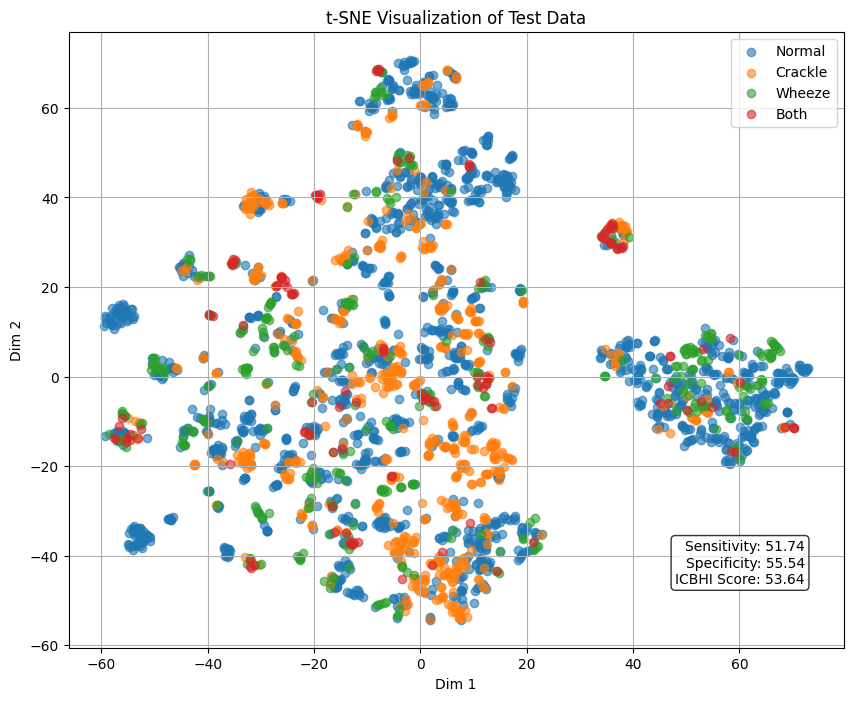

In [54]:
BYOL_EVALUATION(FINETUNE_CHECKPOINT_PATH, config_path='icbhi_config.yaml')
# BYOL_EVALUATION(temp_path_2, config_path='icbhi_config.yaml')